# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [1]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats
# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

#rounding function
from math import ceil



### Sample Size Calculation

In [2]:
# Calculate effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.06, 0.09) # calculating effect size using current conversion rate 
                                                    # & successfully increase conversion rate

In [3]:
# Calculate sample size needed
required_sample_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1) 

required_sample_n = ceil(required_sample_n) # rounding to whole #
print('The required sample size is', required_sample_n)

The required sample size is 1199


### Collecting and preparing the data

In [4]:
# Load the tiktok_data.csv into a dataframe
df = pd.read_csv('tiktok_data.csv')
df.head()

,user_id,timestamp,group,button,liked
0,767017,2017-01-12 22:58:15,control,star,0
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1


In [5]:
# Get the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [6]:
# Make sure all the control group are seeing the star button and viceversa
pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,136002,1816
treatment,1855,136108


In [7]:
df_control = df.loc[(df['group'] == 'control')]
df_control = df_control[df['button'] != 'heart']

df_treat = df.loc[(df['group'] == 'treatment')]
df_treat = df_treat[df['button'] != 'star']

df_clean = pd.concat([df_control, df_treat], ignore_index=True)
df = df_clean

<ipython-input-7-1cbe16022e1e>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_control = df_control[df['button'] != 'heart']
<ipython-input-7-1cbe16022e1e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_treat = df_treat[df['button'] != 'star']


In [8]:
pd.crosstab(df['group'], df['button']) # checking to make sure all the control group are seeing are star buttons & vice-versa

button,heart,star
group,,
control,0,1816
treatment,1855,0


In [9]:
# Check that no users have been sampled multiple times 
users_sample_counts = df['user_id'].value_counts(ascending=False)
n_users_counted_mult = users_sample_counts[users_sample_counts > 1].count()

print('The number of users sampled multiple times is', n_users_counted_mult)

The number of users sampled multiple times is 0


In [10]:
# If there are users who have been sampled multiple times, remove them from the dataframe
users_to_drop = users_sample_counts[users_sample_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]

print('Remaining number of user samples is', df.shape[0])

Remaining number of user samples is 3671


#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [11]:
# Perform simple random sampling to split the data into control and treatment

control_sample = df[df['group'] == 'control'].sample(n=required_sample_n, random_state=22) # Note to self: n = 1199 here though

treatment_sample = df[df['group'] == 'treatment'].sample(n=required_sample_n, random_state=22)

In [12]:
# Create one table called ab_test that has both the cleaned control and treatment data
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,button,liked
0,839043,2017-01-21 12:11:01,control,star,0
1,683859,2017-01-11 21:42:29,control,star,0
2,878651,2017-01-20 23:07:32,control,star,0
3,671533,2017-01-18 17:44:40,control,star,0
4,764640,2017-01-10 1:59:44,control,star,0
...,...,...,...,...,...
2393,852215,2017-01-22 14:04:57,treatment,heart,0
2394,870505,2017-01-20 10:36:07,treatment,heart,1
2395,830824,2017-01-19 6:12:09,treatment,heart,0
2396,898395,2017-01-22 19:40:05,treatment,heart,0


In [13]:
# Count the test groups to make sure that they're balanced 
ab_test['group'].value_counts()

treatment    1199
control      1199
Name: group, dtype: int64

### Analysis Visualization

In [18]:
# Find the like rate by group
like_rates = ab_test.groupby('group')['liked']

# Find the Std. deviation of the proportion
proportion_std = lambda x: np.std(x)

# Find the Std. error of the proportion (std / sqrt(n))
proportion_std_error = lambda x: stats.sem(x)  

# Calculate the final like rate
like_rates = like_rates.agg([np.mean, proportion_std, proportion_std_error])
like_rates.columns = ['like rate', 'std', 'std_error']
like_rates.style.format('{:.3f}')

,like rate,std,std_error
group,,,
control,0.118,0.323,0.009
treatment,0.126,0.332,0.010


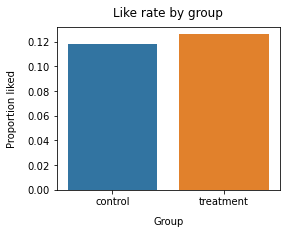

In [28]:
# Plot the like rate by group on a bar plot
plt.figure(figsize=(4,3))

sns.barplot(x=ab_test['group'], y=ab_test['liked'], ci=False)

plt.title('Like rate by group', pad=10) # Note to self: pad seems to mean how close the label is to the graph
plt.xlabel('Group', labelpad=10)
plt.ylabel('Proportion liked', labelpad=10);

### Testing for Stat Sig

In [34]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Get the like count for both control and treatment groups
control_results = ab_test[ab_test['group'] == 'control']['liked']
treatment_results = ab_test[ab_test['group'] == 'treatment']['liked']

# Get the number of samples in both groups
n_control = control_results.count()
n_treatment = treatment_results.count()

# Sum up the number of successes (likes) in both groups
n_successes = [control_results.sum(), treatment_results.sum()]

print('The number of samples in the control group is', n_control)
print('The number of samples in the treatment group is', n_treatment)
print('The number of likes is', n_successes)

The number of samples in the control group is 1199
The number of samples in the treatment group is 1199
The number of likes is [142, 151]


In [35]:
# Find the z statistic and p value for proportions based on normal ztest
nobs = [n_control, n_treatment]

z_stat, p_value = proportions_ztest(n_successes, nobs=nobs)

# Find the confidence intervals for each test group
(lower_control, lower_treatment), (upper_control, upper_treatment) = proportion_confint(n_successes, nobs=nobs, alpha=0.05)

In [43]:
# print z statistic
print(f'z statistic: {z_stat:.2f}')

# print p-value
print(f'p-value: {p_value:.3f}')

# print ci 95% for control group
print(f'ci 95% for control group: [{lower_control:.3f}, {upper_control:.3f}]')

# print ci 95% for treatment group
print(f'ci 95% for treatment group: [{lower_treatment:.3f}, {upper_treatment:.3f}]')

z statistic: -0.56
p-value: 0.575
ci 95% for control group: [0.100, 0.137]
ci 95% for treatment group: [0.107, 0.145]


### Were the results signficant? 

In [49]:
print('Yes. The results were significant, because the confidence interval for the treatment group is 10.7% to 14.5%, ' + 
      'which is higher than the target value of 9%. This means that we surpassed the increase that we was aiming for.')

Yes. The results were significant, because the confidence interval for the treatment group is 10.7% to 14.5%, which is higher than the target value of 9%. This means that we surpassed the increase that we was aiming for.


### What would you advise the engineering team to do moving forward?

In [48]:
print('I would suggest the engineering team switch to using the star button for an increasingly larger amount of users ' +
     '(treatment group) while our team keeps an eye on the changing engagement rate, to see if it would ever fall ' + 
     'below the previous rate of 6%. If it does, they should change back to using the heart button.')

I would suggest the engineering team switch to using the star button for an increasingly larger amount of users (treatment group) while our team keeps an eye on the changing engagement rate, to see if it would ever fall below the previous rate of 6%. If it does, they should change back to using the heart button.
